# Day 2: Transaction Costs & Break-Even Analysis

## Week 12 - Backtesting & Validation

### 🎯 Learning Objectives
- Understand all components of transaction costs
- Model costs in backtests realistically
- Calculate break-even analysis
- Optimize strategy for cost efficiency

### ⏱️ Time Allocation
- Theory review: 30 min
- Guided exercises: 90 min
- Practice problems: 60 min
- Interview prep: 30 min

---

**Author**: ML Quant Finance Mastery  
**Difficulty**: Intermediate  
**Prerequisites**: Day 1 Performance Metrics

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Download market data
print("📥 Downloading market data...")
tickers = ['SPY', 'AAPL', 'MSFT']
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} days of data")

📥 Downloading market data...
✅ Loaded 752 days of data


## 2. Components of Transaction Costs

### Cost Breakdown

1. **Commission**: Fixed fee per trade (~$0-$5 for retail)
2. **Bid-Ask Spread**: Half-spread per trade (~1-50 bps)
3. **Slippage**: Execution uncertainty (~1-10 bps)
4. **Market Impact**: Your order moves the price (~varies with size)

In [2]:
class TransactionCostModel:
    """
    Comprehensive transaction cost model
    """
    def __init__(self, commission_per_share=0.005, 
                 spread_bps=5, 
                 slippage_bps=2,
                 impact_coefficient=0.1):
        """
        Parameters:
        -----------
        commission_per_share : float
            Fixed commission per share
        spread_bps : float
            Bid-ask spread in basis points
        slippage_bps : float
            Expected slippage in basis points
        impact_coefficient : float
            Market impact coefficient (impact = coef * sqrt(participation_rate) * volatility)
        """
        self.commission_per_share = commission_per_share
        self.spread = spread_bps / 10000
        self.slippage = slippage_bps / 10000
        self.impact_coef = impact_coefficient
    
    def calculate_costs(self, trade_value, avg_price, daily_volume, volatility):
        """
        Calculate total transaction cost for a trade
        """
        shares = trade_value / avg_price
        
        # Commission
        commission = self.commission_per_share * abs(shares)
        commission_pct = commission / abs(trade_value) if trade_value != 0 else 0
        
        # Spread (half the spread each way)
        spread_cost = abs(trade_value) * self.spread / 2
        spread_pct = self.spread / 2
        
        # Slippage
        slippage_cost = abs(trade_value) * self.slippage
        slippage_pct = self.slippage
        
        # Market impact (simplified square-root model)
        participation_rate = abs(shares) / daily_volume if daily_volume > 0 else 0
        impact_pct = self.impact_coef * np.sqrt(participation_rate) * volatility
        impact_cost = abs(trade_value) * impact_pct
        
        total_cost = commission + spread_cost + slippage_cost + impact_cost
        total_pct = commission_pct + spread_pct + slippage_pct + impact_pct
        
        return {
            'commission': commission,
            'spread': spread_cost,
            'slippage': slippage_cost,
            'impact': impact_cost,
            'total': total_cost,
            'total_pct': total_pct
        }

# Example
cost_model = TransactionCostModel()
example_costs = cost_model.calculate_costs(
    trade_value=100000,      # $100k trade
    avg_price=150,           # $150 per share
    daily_volume=50000000,   # 50M shares daily
    volatility=0.02          # 2% daily vol
)

print("📊 TRANSACTION COST BREAKDOWN")
print("=" * 50)
print(f"Trade Size: $100,000")
print("-" * 50)
for component, value in example_costs.items():
    if 'pct' in component:
        print(f"{component:<15}: {value:.4%}")
    else:
        print(f"{component:<15}: ${value:.2f}")

📊 TRANSACTION COST BREAKDOWN
Trade Size: $100,000
--------------------------------------------------
commission     : $3.33
spread         : $25.00
slippage       : $20.00
impact         : $0.73
total          : $49.06
total_pct      : 0.0491%


## 3. Backtest with Transaction Costs

In [3]:
def backtest_with_costs(signals, returns, cost_bps=10):
    """
    Backtest strategy with transaction costs
    
    Parameters:
    -----------
    signals : array
        Position signals (-1, 0, 1)
    returns : array
        Asset returns
    cost_bps : float
        Round-trip cost in basis points
    """
    cost = cost_bps / 10000
    
    # Position changes (turnover)
    position_changes = np.abs(np.diff(signals, prepend=0))
    
    # Gross returns
    gross_returns = signals * returns
    
    # Transaction costs
    transaction_costs = position_changes * cost
    
    # Net returns
    net_returns = gross_returns - transaction_costs
    
    return {
        'gross': gross_returns,
        'net': net_returns,
        'costs': transaction_costs,
        'turnover': position_changes.sum()
    }

# Create a momentum strategy
spy_returns = returns['SPY'].values

# 20-day momentum signal
momentum = pd.Series(spy_returns).rolling(20).mean()
signal = np.sign(momentum.values)
signal = np.nan_to_num(signal)

# Test with different cost assumptions
cost_levels = [0, 5, 10, 20, 30, 50]

print("📊 STRATEGY PERFORMANCE VS COSTS")
print("=" * 70)
print(f"{'Cost (bps)':<12} {'Sharpe':<10} {'Annual Ret':<12} {'Turnover':<12}")
print("-" * 70)

for cost in cost_levels:
    result = backtest_with_costs(signal, spy_returns, cost)
    sharpe = np.mean(result['net']) / np.std(result['net']) * np.sqrt(252)
    annual_ret = np.mean(result['net']) * 252
    turnover = result['turnover']
    print(f"{cost:<12} {sharpe:<10.2f} {annual_ret:<12.2%} {turnover:<12.0f}")

📊 STRATEGY PERFORMANCE VS COSTS
Cost (bps)   Sharpe     Annual Ret   Turnover    
----------------------------------------------------------------------
0            2.80       41.56%       99          
5            2.71       39.90%       99          
10           2.61       38.24%       99          
20           2.40       34.92%       99          
30           2.18       31.59%       99          
50           1.72       24.95%       99          


## 4. Break-Even Analysis

📊 BREAK-EVEN ANALYSIS
Strategy breaks even (Sharpe = 0) at: 125 bps
Strategy is viable (Sharpe = 0.5) at: 102 bps


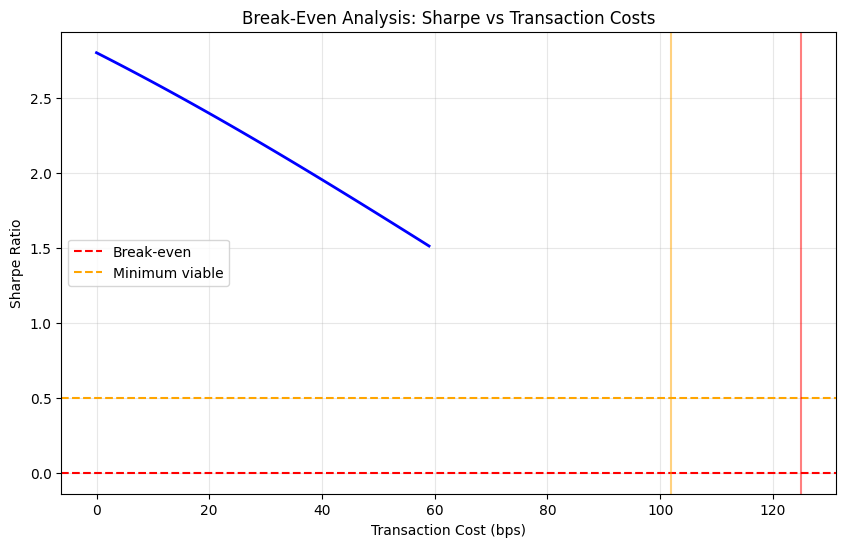

In [4]:
def find_breakeven_cost(signals, returns, target_sharpe=0.0):
    """
    Find cost level where strategy breaks even (Sharpe = target)
    """
    for cost in range(0, 200):  # Up to 200 bps
        result = backtest_with_costs(signals, returns, cost)
        sharpe = np.mean(result['net']) / np.std(result['net']) * np.sqrt(252)
        if sharpe < target_sharpe:
            return cost - 1
    return 200

# Calculate break-even
breakeven_zero = find_breakeven_cost(signal, spy_returns, target_sharpe=0.0)
breakeven_half = find_breakeven_cost(signal, spy_returns, target_sharpe=0.5)

print("📊 BREAK-EVEN ANALYSIS")
print("=" * 50)
print(f"Strategy breaks even (Sharpe = 0) at: {breakeven_zero} bps")
print(f"Strategy is viable (Sharpe = 0.5) at: {breakeven_half} bps")

# Visualize
costs_range = range(0, 60)
sharpes = []
for cost in costs_range:
    result = backtest_with_costs(signal, spy_returns, cost)
    sharpe = np.mean(result['net']) / np.std(result['net']) * np.sqrt(252)
    sharpes.append(sharpe)

plt.figure(figsize=(10, 6))
plt.plot(costs_range, sharpes, 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', label='Break-even')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Minimum viable')
plt.axvline(x=breakeven_zero, color='r', alpha=0.5)
plt.axvline(x=breakeven_half, color='orange', alpha=0.5)
plt.xlabel('Transaction Cost (bps)')
plt.ylabel('Sharpe Ratio')
plt.title('Break-Even Analysis: Sharpe vs Transaction Costs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Turnover Optimization

In [5]:
def optimize_signal_threshold(returns, lookback=20, thresholds=[0, 0.001, 0.002, 0.005, 0.01]):
    """
    Optimize signal threshold to reduce turnover
    
    Only change position if momentum exceeds threshold
    """
    results = []
    
    for threshold in thresholds:
        # Calculate momentum
        momentum = pd.Series(returns).rolling(lookback).mean()
        
        # Apply threshold (hysteresis)
        signal = np.zeros(len(returns))
        for i in range(1, len(momentum)):
            if momentum.iloc[i] > threshold:
                signal[i] = 1
            elif momentum.iloc[i] < -threshold:
                signal[i] = -1
            else:
                signal[i] = signal[i-1]  # Keep previous position
        
        # Calculate turnover
        turnover = np.abs(np.diff(signal, prepend=0)).sum()
        
        # Backtest with costs
        result = backtest_with_costs(signal, returns, cost_bps=10)
        sharpe = np.mean(result['net']) / np.std(result['net']) * np.sqrt(252)
        
        results.append({
            'threshold': threshold,
            'turnover': turnover,
            'sharpe': sharpe
        })
    
    return pd.DataFrame(results)

# Optimize
optimization_results = optimize_signal_threshold(spy_returns)

print("📊 TURNOVER OPTIMIZATION")
print("=" * 50)
print(optimization_results.to_string(index=False))
print("\n💡 Higher threshold = less turnover = lower costs = potentially higher net Sharpe")

📊 TURNOVER OPTIMIZATION
 threshold  turnover   sharpe
     0.000      99.0 2.605511
     0.001      31.0 1.074870
     0.002      19.0 0.690858
     0.005       5.0 0.828115
     0.010       0.0      NaN

💡 Higher threshold = less turnover = lower costs = potentially higher net Sharpe


## 6. ⏱️ TIMED CODING CHALLENGE (30 minutes)

**Challenge:** Build a cost-aware backtester that:
1. Accepts a signal generator function
2. Calculates gross and net performance
3. Provides break-even analysis
4. Suggests optimal cost budget

In [6]:
# YOUR CODE HERE
class CostAwareBacktester:
    def __init__(self, returns, cost_bps=10):
        """Initialize backtester"""
        # TODO: Implement
        pass
    
    def run(self, signal_func):
        """Run backtest with given signal generator"""
        # TODO: Implement
        pass
    
    def breakeven_analysis(self):
        """Calculate break-even cost"""
        # TODO: Implement
        pass
    
    def report(self):
        """Generate comprehensive report"""
        # TODO: Implement
        pass

# Test your implementation
# backtester = CostAwareBacktester(spy_returns, cost_bps=10)
# backtester.run(lambda x: np.sign(pd.Series(x).rolling(20).mean().values))
# backtester.report()

## 7. Interview Question of the Day

**Q: How would you estimate market impact for a large institutional order?**

Think about:
1. Square-root model of market impact
2. Factors affecting impact (volatility, volume, order size)
3. Optimal execution strategies (TWAP, VWAP, Implementation Shortfall)

In [7]:
# Market Impact Demonstration
def square_root_impact(order_size, daily_volume, volatility, coefficient=0.1):
    """
    Square-root market impact model
    
    Impact = coefficient * volatility * sqrt(order_size / daily_volume)
    
    This is the standard model used by most institutions
    """
    participation_rate = order_size / daily_volume
    impact = coefficient * volatility * np.sqrt(participation_rate)
    return impact

# Demonstrate impact scaling
order_sizes = [0.01, 0.05, 0.1, 0.2, 0.5]  # As % of daily volume
daily_vol = 1e8  # $100M daily volume
volatility = 0.02  # 2% daily vol

print("📊 MARKET IMPACT SCALING")
print("=" * 50)
print(f"{'Order Size (% ADV)':<20} {'Impact (bps)'}")
print("-" * 50)
for size in order_sizes:
    impact = square_root_impact(size * daily_vol, daily_vol, volatility)
    print(f"{size*100:>6.0f}%{'':<13} {impact*10000:>6.1f}")

print("\n💡 Impact grows with sqrt(size) - doubling order size increases impact by ~41%")

📊 MARKET IMPACT SCALING
Order Size (% ADV)   Impact (bps)
--------------------------------------------------
     1%                 2.0
     5%                 4.5
    10%                 6.3
    20%                 8.9
    50%                14.1

💡 Impact grows with sqrt(size) - doubling order size increases impact by ~41%


## 8. Key Takeaways

| Concept | Key Point |
|---------|-----------|
| Cost Components | Commission + Spread + Slippage + Impact |
| Break-Even | Find cost level where Sharpe = 0 |
| Turnover | Lower turnover = lower costs |
| Impact | Grows with sqrt(order size) |
| Optimization | Balance signal strength vs trading frequency |

---

**Tomorrow:** Walk-Forward Validation